<a id = "table-of-contents"></a>
# Table of Contents
- [Import data](#import)
- [EDA](#eda)
- [Modelling](#modelling)
- [Submission](#submission)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
%matplotlib inline

2023-01-21 15:47:56.732308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 15:47:57.104829: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 15:47:57.104862: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-21 15:47:58.148540: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# for CNN from scratch
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# for pre-trained CNN
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from keras.callbacks import EarlyStopping

In [4]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [ ]:
print('Python       :', sys.version.split("\n")[0])
print('FastAI       :', fastai.__version__)
print('Numpy        :', np.__version__)
print('Torch        :', torch.__version__)
print('CUDA         :', torch.cuda.is_available())

<a id = "import"></a>
# <b><span style='color:#4797ef'>|</span> Import Data</b>

In [11]:
df = pd.read_csv('../data/train.csv', dtype = {'Id': str})
df.head()

,Id,label
0,0560,glass
1,4675,cup
2,0875,glass
3,4436,spoon
4,8265,plate


<a id = "eda"></a>
# <b><span style='color:#4797ef'>|</span> EDA</b>

In [12]:
label_group = df.groupby('label').size().to_frame(name="count")

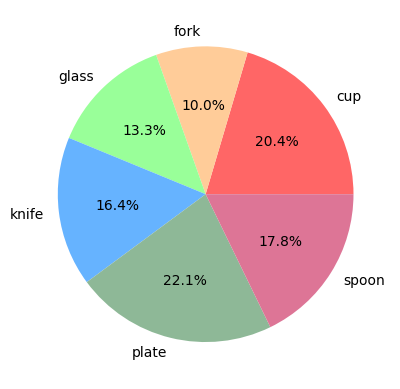

In [13]:
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff', '#8EB897', '#DD7596']

plt.pie(label_group["count"], labels=label_group.index, colors=colors, autopct='%.1f%%')
plt.show() 

The dataset contains 6 classes: plate(22.1%), knife(16.4%), glass(13.3%), fork(10%), cup(20.4%), spoon(17.8%) 

## First look at the images

In [14]:
df["filename"] = '../data/images/' + df['Id'] + '.jpg'

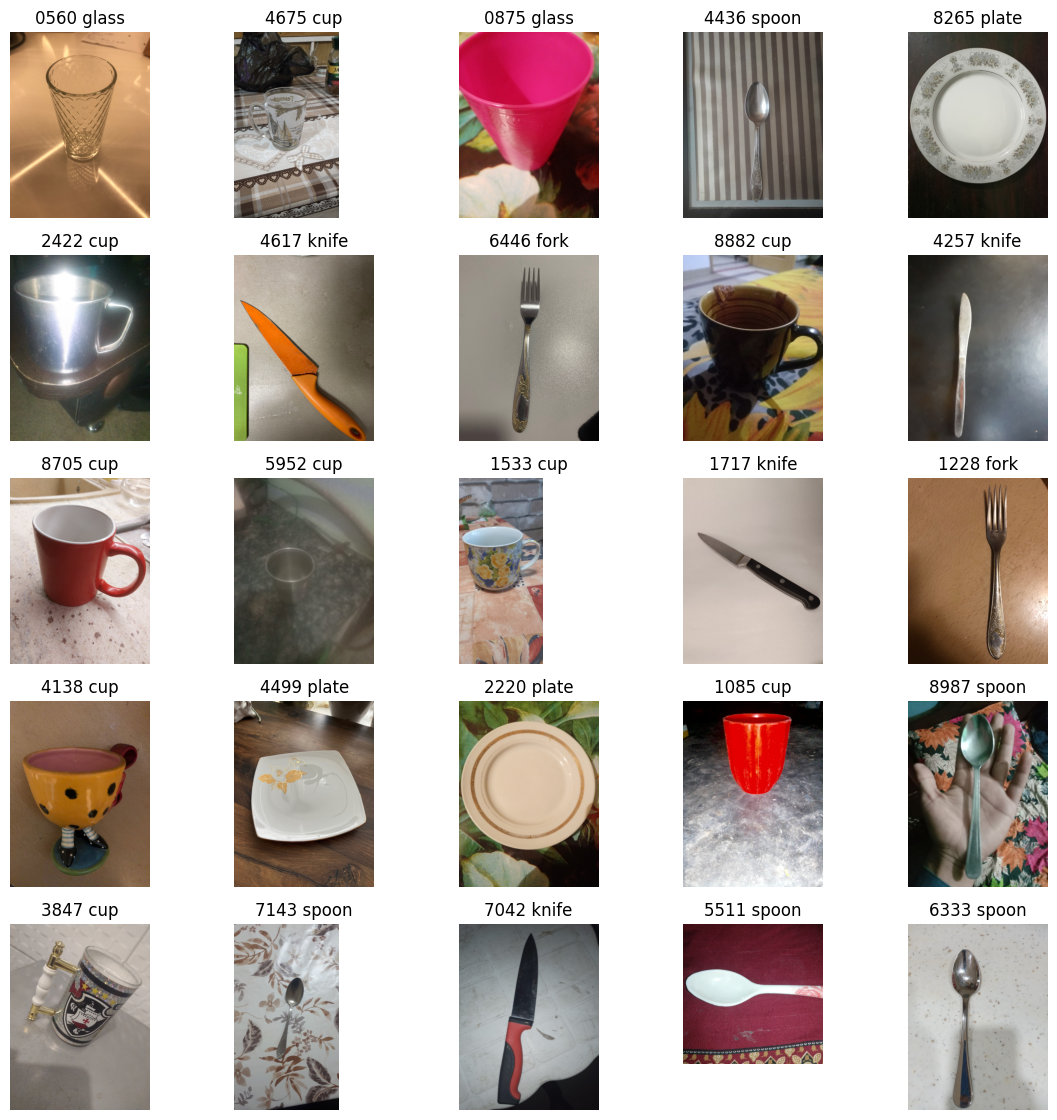

In [15]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(14,14))
 
for i, row in df[0:25].iterrows():
    img = load_img(row["filename"])
    label = row["label"]
    Id = row["Id"]
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(Id + " " + label)
    plt.axis("off")

After examining the data, it was found that the image quality (sharpness/resolution) in some of the photos is poor, the subject is not fully displayed in the photo. Most of the subjects are shown empty, but some, such as plates, are shown filled with food. 

Because of the size of the dataset, we will not manually review and exclude such cases. These cases will make our model more ready for unexpected images.

Objects are shown from various angles that's why we'll use data augmentation.

<a id = "modelling"></a>
# <b><span style='color:#4797ef'>|</span> Modelling</b>

In [16]:
threshold = int(len(df) * 0.8)

df_train = df[:threshold]
df_val = df[threshold:]

In [11]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3),
                        activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8), 
              metrics=['acc'])

2023-01-20 17:10:53.458114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-20 17:10:53.458130: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-20 17:10:53.458144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kiryl-computer): /proc/driver/nvidia/version does not exist
2023-01-20 17:10:53.458288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 11,216,198
Trainable params: 11,216,198
Non-trainable params: 0
____________________________________________

In [13]:
def compare_histories(history):
    acc = history.history['acc']
    test_acc = history.history['val_acc']
    loss = history.history['loss']
    test_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axis = plt.subplots(1, 2, figsize=(24,8))

    axis[0].plot(epochs, acc, label='Training acc')
    axis[0].plot(epochs, test_acc, label='Test acc')
    axis[0].set_title('Training and Test Accuracy')
    axis[0].legend()

    axis[1].plot(epochs, loss, label='Training loss')
    axis[1].plot(epochs, test_loss, label='Test loss')
    axis[1].set_title('Training and Test Loss')
    axis[1].legend()

## CNN from scratch

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(df_val,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [15]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/basic_CNN_best.h5',
    save_best_only=True,
    monitor='val_acc',
    mode='max'
)

In [16]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint])

Epoch 1/10
223/223 [==============================] - 45s 202ms/step - loss: 1.7335 - acc: 0.2566 - val_loss: 1.6676 - val_acc: 0.3049
Epoch 2/10
223/223 [==============================] - 44s 196ms/step - loss: 1.6519 - acc: 0.2944 - val_loss: 1.6370 - val_acc: 0.3363
Epoch 3/10
223/223 [==============================] - 44s 199ms/step - loss: 1.6035 - acc: 0.3310 - val_loss: 1.5743 - val_acc: 0.3543
Epoch 4/10
223/223 [==============================] - 44s 197ms/step - loss: 1.5603 - acc: 0.3641 - val_loss: 1.5608 - val_acc: 0.3417
Epoch 5/10
223/223 [==============================] - 43s 192ms/step - loss: 1.5282 - acc: 0.3701 - val_loss: 1.5725 - val_acc: 0.3543
Epoch 6/10
223/223 [==============================] - 43s 195ms/step - loss: 1.4904 - acc: 0.3895 - val_loss: 1.4765 - val_acc: 0.3966
Epoch 7/10
223/223 [==============================] - 44s 197ms/step - loss: 1.4504 - acc: 0.4077 - val_loss: 1.5303 - val_acc: 0.3597
Epoch 8/10
223/223 [==============================] - 4

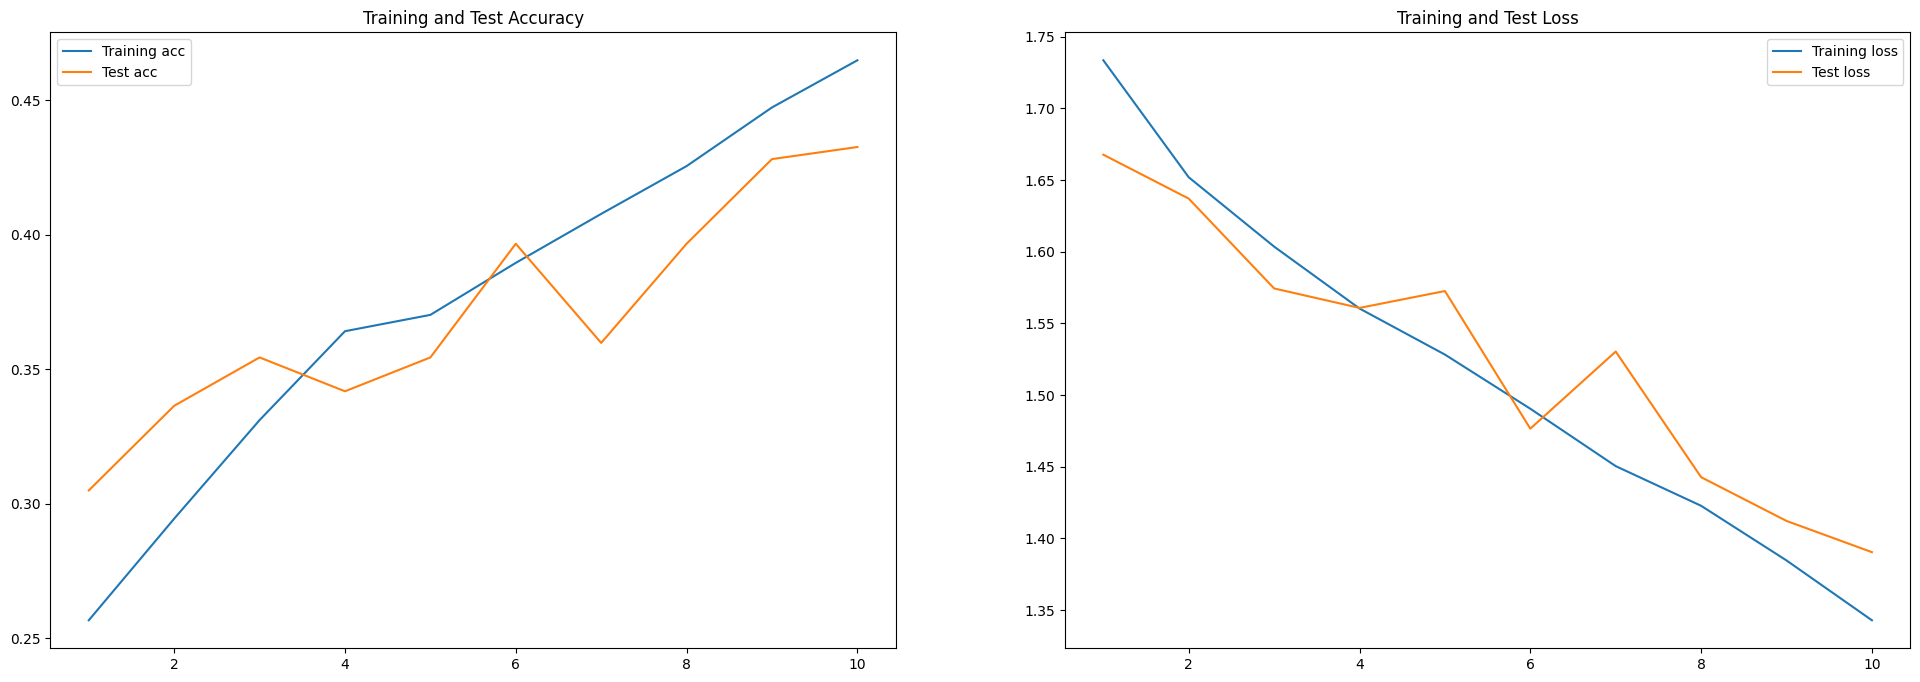

In [17]:
compare_histories(history=history)

In [18]:
model.save("../models/basic_CNN")

INFO:tensorflow:Assets written to: ../models/basic_CNN/assets


INFO:tensorflow:Assets written to: ../models/basic_CNN/assets


### Add augmentation 

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255, # don't forget this...
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 4447 validated image filenames belonging to 6 classes.


In [20]:
train_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [21]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(df_val,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True)

Found 1112 validated image filenames belonging to 6 classes.


In [22]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/CNN_aug_best.h5',
    save_best_only=True,
    monitor='val_acc',
    mode='max'
)

In [23]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint])

Epoch 1/10
223/223 [==============================] - 54s 241ms/step - loss: 1.5859 - acc: 0.3551 - val_loss: 1.4297 - val_acc: 0.4128
Epoch 2/10
223/223 [==============================] - 53s 240ms/step - loss: 1.5652 - acc: 0.3562 - val_loss: 1.4130 - val_acc: 0.4146
Epoch 3/10
223/223 [==============================] - 53s 236ms/step - loss: 1.5620 - acc: 0.3686 - val_loss: 1.4531 - val_acc: 0.4047
Epoch 4/10
223/223 [==============================] - 53s 236ms/step - loss: 1.5484 - acc: 0.3645 - val_loss: 1.4096 - val_acc: 0.4254
Epoch 5/10
223/223 [==============================] - 54s 240ms/step - loss: 1.5495 - acc: 0.3647 - val_loss: 1.3946 - val_acc: 0.4335
Epoch 6/10
223/223 [==============================] - 54s 242ms/step - loss: 1.5279 - acc: 0.3751 - val_loss: 1.4153 - val_acc: 0.4236
Epoch 7/10
223/223 [==============================] - 54s 244ms/step - loss: 1.5252 - acc: 0.3803 - val_loss: 1.3779 - val_acc: 0.4335
Epoch 8/10
223/223 [==============================] - 5

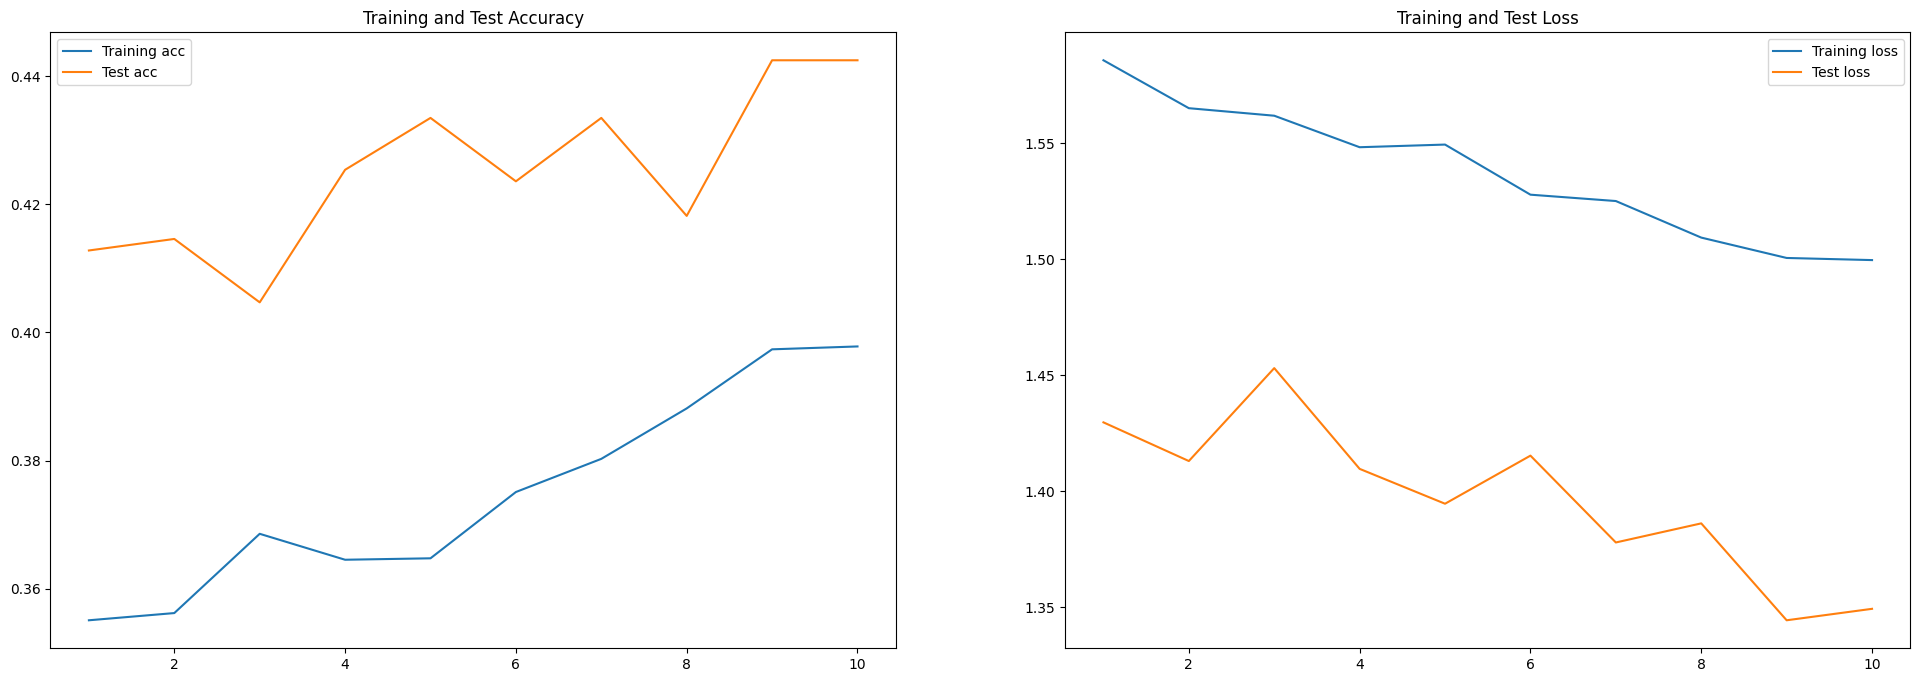

In [24]:
compare_histories(history=history)

In [25]:
model.save("../models/CNN_aug")

INFO:tensorflow:Assets written to: ../models/CNN_aug/assets


INFO:tensorflow:Assets written to: ../models/CNN_aug/assets


## Pre-trained CNN - Xception + tune parameter

In [31]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [17]:
# train_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train_Xc_generator = train_xc_datagen.flow_from_dataframe(
#     df_train,
#     x_col='filename',
#     y_col='label',
#     target_size=(299, 299),
#     batch_size=32
# )

train_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_Xc_generator = train_Xc_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32)

Found 4447 validated image filenames belonging to 6 classes.


In [33]:
val_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_Xc_generator = val_Xc_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32
)

Found 1112 validated image filenames belonging to 6 classes.


In [34]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/Xception_best.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [35]:
lr2history = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_Xc_generator,
                        epochs=10,
                        validation_data=val_Xc_generator,
                        callbacks=[checkpoint])
    lr2history[lr] = history.history
    print("\n\n")

0.0001
Epoch 1/10
139/139 [==============================] - 692s 5s/step - loss: 1.3381 - accuracy: 0.6532 - val_loss: 0.9505 - val_accuracy: 0.8822
Epoch 2/10
139/139 [==============================] - 662s 5s/step - loss: 0.8262 - accuracy: 0.8687 - val_loss: 0.6047 - val_accuracy: 0.9290
Epoch 3/10
139/139 [==============================] - 619s 4s/step - loss: 0.5983 - accuracy: 0.8999 - val_loss: 0.4412 - val_accuracy: 0.9344
Epoch 4/10
139/139 [==============================] - 618s 4s/step - loss: 0.4769 - accuracy: 0.9103 - val_loss: 0.3535 - val_accuracy: 0.9406
Epoch 5/10
139/139 [==============================] - 642s 5s/step - loss: 0.4047 - accuracy: 0.9130 - val_loss: 0.2981 - val_accuracy: 0.9469
Epoch 6/10
139/139 [==============================] - 644s 5s/step - loss: 0.3633 - accuracy: 0.9199 - val_loss: 0.2656 - val_accuracy: 0.9496
Epoch 7/10
139/139 [==============================] - 638s 5s/step - loss: 0.3357 - accuracy: 0.9177 - val_loss: 0.2405 - val_accuracy:

In [ ]:
epochs = range(1, 11)
for lr, hist in lr2history.items():
    plt.plot(epochs, hist['val_accuracy'], label=('lr=%s' % lr))
plt.legend()
plt.show()

At lr equal to 0.001, the model looks more stable and achieves a higher accuracy on validation data

In [ ]:
model = make_model(learning_rate=0.001)
es = EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.980)

history = model.fit(train_Xc_generator,
                    epochs=10,
                    validation_data=val_Xc_generator,
                    callbacks=[es])

In [ ]:
model.save("../models/XCeption_aug")

<a id = "submission"></a>
# <b><span style='color:#4797ef'>|</span> Submission</b>

In [25]:
df_test = pd.read_csv('../data/test.csv', dtype = {'Id': str})
df_test['filename'] = '../data/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,../data/images/0678.jpg
1,3962,../data/images/3962.jpg
2,9271,../data/images/9271.jpg
3,5133,../data/images/5133.jpg
4,8842,../data/images/8842.jpg


In [26]:
test_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_Xc_generator = test_Xc_datagen.flow_from_dataframe(df_test,
                                                        x_col='filename',
                                                        class_mode='input',
                                                        target_size=(299, 299),
                                                        batch_size=32,
                                                        shuffle=False)

Found 3808 validated image filenames.


In [27]:
model = keras.models.load_model('../models/Xception_best.h5')

In [39]:
y_pred = model.predict(test_Xc_generator)

119/119 [==============================] - 266s 2s/step


In [40]:
classes = np.array(list(train_Xc_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [41]:
predictions = classes[y_pred.argmax(axis=1)]

<BarContainer object of 6 artists>

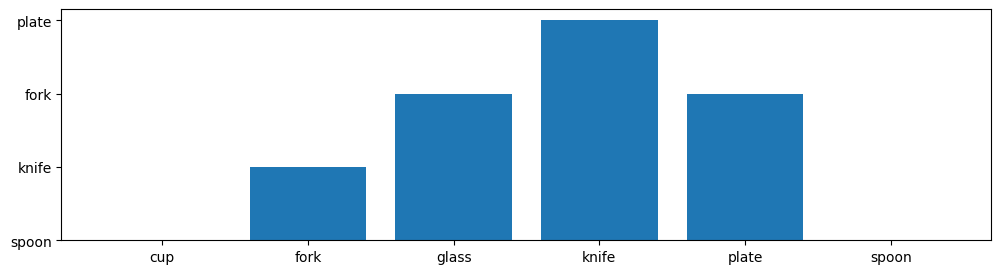

In [33]:
classes, predictions = zip(*dict(zip(classes, predictions)).items())
plt.figure(figsize=(12, 3))
plt.bar(classes, predictions)

In [46]:
df_submission = pd.DataFrame()

df_submission['label'] = predictions
df_submission['Id'] = df_test['Id']

In [48]:
df_submission[['label', 'Id']].to_csv('../data/submission.csv', index=False)